Guia de como ejecutar:
1-Ejecutar los imports primero
2-Todo lo que esta antes de "Subset de todas las lineas para los graficos de presentacion" es para formatear el dataset del gobierno y separar la linea D
3-Todo lo que esta despues de "Subset de todas las lineas para los graficos de presentacion" es para sacar los graficos para la presentacion
4-Para ejecutar la parte de los issues van a necesitar el dataset "Twittermetrovias.csv" que esta subido en git
5-Para los graficos de plotly fijense en este link para configurar, yo en windows no pude encontrar el file que es necesario modificar
https://plot.ly/python/getting-started/

In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
from datetime import datetime
import numpy as np
pd.set_option('float_format', '{:,f}'.format)

import sys
import plotly 
import plotly.plotly as py




Levantar el archivo de molinetes 2018, formatearlo y guardar solo la linea D ( se puede elegir que linea guardar)

In [ ]:

mol_2018 = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\Mol 2018.csv', sep=",")

mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018['Year'] = pd.DatetimeIndex(mol_2018['FECHA']).year

mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018['TOTAL'].fillna(0, inplace=True)
mol_2018.dropna(how='any', inplace=True)
mol_2018=mol_2018[mol_2018['MOLINETE'].apply(lambda x: "LINEA_D" in x )]


mol_2018.to_csv("Linea_D_sintwitt.csv", sep=';', encoding='utf-8')

Abrir el csv una vez guardado (si se corre antes el codigo de arriba y queda el df en la variable mol_2018 usar ese en vez de LIND, obviamente reemplazando LIND por mol_2018), formatearlo y juntar el del twitter

In [ ]:
LIND = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\Linea_D_sintwitt.csv', sep=";")

LIND['FECHA'] = pd.to_datetime(pd.Series(LIND['FECHA']), format="%Y/%m/%d")
LIND['DESDE'] =pd.to_datetime(pd.Series(LIND['DESDE']), format='%H:%M:%S')

#esto es para filtrar
#LIND[LIND['DESDE'] > datetime.strptime("08:00:00",'%X')]


TWD = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\TweetD.csv', sep=";")

TWD['DATE'] = pd.to_datetime(pd.Series(TWD['DATE']), format="%Y/%m/%d")
TWD['TIME'] =pd.to_datetime(pd.Series(TWD['TIME']), format='%H:%M:%S')

TWD.rename(columns={'DATE': 'FECHA'}, inplace=True)

#TWD.drop(['Unnamed: 0'],axis=1,inplace=True)
TWD.drop(['Linea D'],axis=1,inplace=True)
TWD.drop(['Demora'],axis=1,inplace=True)
TWD.drop(['Sinterrumpido'],axis=1,inplace=True)
TWD.drop(['Snormal'],axis=1,inplace=True)
TWD.drop(['Slimitado'],axis=1,inplace=True)
TWD.drop(['SdemFG'],axis=1,inplace=True)

TWD['Issuetype']=TWD['TEXT'].apply(lambda x: 'demora' if 'demora' in x else 'interrumpido' if 'interrumpido' in x else 'Normal' if 'frecuencia normal' in x else 'limitado' if 'limitado' in x else 'Normal')


def standdate(timestr):
    if (timestr.minute < 15 and timestr.minute >= 00):
        ab =(str('{:02d}'.format(timestr.hour)) + ":00:00")
    elif (timestr.minute >= 15 and timestr.minute < 30):
        ab =(str('{:02d}'.format(timestr.hour)) + ":15:00")
    elif (timestr.minute >= 30):
        ab = (str('{:02d}'.format(timestr.hour)) + ":30:00")

    return ab


TWD['DESDE'] = TWD['TIME'].map(standdate)
TWD['DESDE'] =pd.to_datetime(pd.Series(TWD['DESDE']), format='%H:%M:%S')

LINDTWD = pd.merge(LIND,TWD,how='left',on=['FECHA','DESDE'])

LINDTWD['WeekDay'] = LINDTWD['FECHA'].dt.strftime("%A")

#agrega el mean
BMOLmean= LINDTWD.groupby(['ESTACION','WeekDay','DESDE'], as_index=False)['TOTAL'].mean()
BMOLmean.rename(columns={'TOTAL': 'Mean'}, inplace=True)
LINDTWDmean = pd.merge(LINDTWD,BMOLmean,how='left',on=['ESTACION','WeekDay','DESDE'])


LINDTWDmean.to_csv("LineaDcontwit.csv", sep=';', encoding='utf-8')



GRAFICOS (levantar LineaDcontwit.csv)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

from matplotlib.ticker import MaxNLocator
from collections import namedtuple



Total por mes

In [ ]:
TotPag18 = LINDTWDmean
TotPag18.set_index(["Month"], inplace=True)
TotPag18 = TotPag18.sum(level=["Month"])

TotPag18 = TotPag18.reset_index()


fig, ax = plt.subplots(figsize=(25,10))
ax.plot(TotPag18['Month'], TotPag18['TOTAL'], color='r')
plt.show()


Por dia

In [ ]:
LINDTWDmean = LINDTWDmean.reset_index()
TotPag18 = LINDTWDmean
TotPag18.set_index(["FECHA"], inplace=True)
TotPag18 = TotPag18.sum(level=["FECHA"])

TotPag18 = TotPag18.reset_index()

TotPag18= TotPag18.sort_values(by='FECHA')


#years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator()  # every month
#yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(50,5))
ax.plot(TotPag18['FECHA'], TotPag18['TOTAL'])


ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

Por Estacion

In [ ]:
LINDTWDmean = LINDTWDmean.reset_index()
TotPag18 = LINDTWDmean
TotPag18.set_index(["ESTACION"], inplace=True)
TotPag18 = TotPag18.sum(level=["ESTACION"])

TotPag18 = TotPag18.reset_index()

#TotPag18= TotPag18.sort_values(by='FECHA')



GRAFICO PIE

In [ ]:
# Pie chart solo 
labels = TotPag18.ESTACION
sizes = TotPag18.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')



fig, axs = plt.subplots(figsize=(30,10))
axs.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     


#fig.tight_layout()

plt.show()

                            
                 

GRAFICO DE BARRAS

In [ ]:
#BAR SOLO
#https://webcache.googleusercontent.com/search?q=cache:WY7G0y4OxQ8J:https://stackoverflow.com/questions/43560801/display-y-axis-value-horizontal-line-drawn-in-bar-chart+&cd=4&hl=es-419&ct=clnk&gl=ar
import matplotlib.colors
fig, ax = plt.subplots(figsize=(25,10))

index = np.arange(TotPag18.ESTACION.count())

bar_width = 0.35
opacity = 0.4

norm = matplotlib.colors.Normalize(30e3, 60e3)
ax.bar(index,TotPag18.TOTAL, bar_width,alpha=opacity,
       color=np.random.rand ( 256,3),
       label='ESTACION')


#rects1 = ax.bar(index, TotPag18.TOTAL, bar_width,
#                alpha=opacity, color='b',
#                label='ESTACION')

#rects2 = ax.bar(index + bar_width, means_women, bar_width,
#                alpha=opacity, color='r',
#                yerr=std_women, error_kw=error_config,
#                label='Women')

#ax.set_xlabel('Group')
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.axhline(TotPag18.TOTAL.mean(), color="gray")
ax.grid(True)
ax.text(1.02, TotPag18.TOTAL.mean(), "Mean: " + str(TotPag18.TOTAL.mean()),transform=ax.get_yaxis_transform())
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(TotPag18.ESTACION)
ax.legend()

fig.tight_layout()
plt.show()

BARRAS Y PIE

In [ ]:
# Pie chart
labels = TotPag18.ESTACION
sizes = TotPag18.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#bar chart
index = np.arange(TotPag18.ESTACION.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots(2, 1, figsize=(30,10))
axs[0].pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     
axs[1].bar(index, TotPag18.TOTAL, bar_width,
                alpha=opacity, color='b',
                label='Estacion')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(TotPag18.ESTACION)
axs[1].legend()


#fig.tight_layout()

plt.show()

                            
                 

In [ ]:

#limpiar las estaciones que estan mal
#LINDTWD['ESTACION']=LINDTWD['ESTACION'].apply(lambda x: 'Aguero' if 'Agüero' in x else x)
#LINDTWD.ESTACION.unique()


In [ ]:
#esto es otro subset que hice para probar algo, no es necesario correrlo
mol_2018 = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\Mol 2018.csv', sep=",")
mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018 = mol_2018[mol_2018.MOLINETE.apply(lambda x: 'LineaD' in x)]


#mol_2018['TOTAL'].fillna(0, inplace=True)


mol_2018.dropna(how='any', inplace=True)
mol_2018.to_csv("Linea_D_sintwitt2.csv", sep=';', encoding='utf-8')



PLOTLY GRAFICOS (MAS DINAMICOS)

Configuracion plotly


In [ ]:
import sys
import plotly 
import plotly.plotly as py
import json
import requests
from requests.auth import HTTPBasicAuth


username = 'alekido' # Replace with YOUR USERNAME
api_key = 'JPkecUvguXvx2Kwehb8G' # Replace with YOUR API KEY

plotly.tools.set_credentials_file(username=username, api_key=api_key)



auth = HTTPBasicAuth(username, api_key)
headers = {'Plotly-Client-Platform': 'python'}
plotly.tools.set_credentials_file(username=username, api_key=api_key)
def get_pages(username, page_size):
    url = 'https://api.plot.ly/v2/folders/all?user='+username+'&page_size='+str(page_size)
    response = requests.get(url, auth=auth, headers=headers)
    if response.status_code != 200:
        return
    page = json.loads(response.content)
    yield page
    while True:
        resource = page['children']['next'] 
        if not resource:
            break
        response = requests.get(resource, auth=auth, headers=headers)
        if response.status_code != 200:
            break
        page = json.loads(response.content)
        yield page
        

def permanently_delete_files(username, page_size=500, filetype_to_delete='plot'):
    for page in get_pages(username, page_size):
        for x in range(0, len(page['children']['results'])):
            fid = page['children']['results'][x]['fid']
            res = requests.get('https://api.plot.ly/v2/files/' + fid, auth=auth, headers=headers)
            res.raise_for_status()
            if res.status_code == 200:
                json_res = json.loads(res.content)
                if json_res['filetype'] == filetype_to_delete:
                    # move to trash
                    requests.post('https://api.plot.ly/v2/files/'+fid+'/trash', auth=auth, headers=headers)
                    # permanently delete
                    requests.delete('https://api.plot.ly/v2/files/'+fid+'/permanent_delete', auth=auth, headers=headers)

                    
                    
                    
                    
permanently_delete_files('alekido', filetype_to_delete='plot')
permanently_delete_files('alekido', filetype_to_delete='grid')

Graficos

In [16]:
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
from datetime import datetime
from plotly import tools

Dos plots uno mixeado

In [ ]:

#df = pd.read_csv('C:\Users\alejandro.m.gizzi\Documents\Mine\LineaDcontwit.csv', sep=";")
#cambiar la ruta de donde esta el archivo
#df = pd.read_csv('/home/ale/Documents/TP FINAL/Areadytoplot.csv', sep=";")
#df['FECHA'] = pd.to_datetime(df['FECHA'])
#df['ESTACION'] = df['ESTACION'].astype('str')
#df['DESDE'] = pd.to_datetime(pd.Series(df['DESDE']), format='%H:%M:%S')

#jueguen con esto para ir filtrando el dataset
sdf = df[(df['ESTACION'] =='Catedral') &  (df['FECHA'] =='2018-04-01')]

#https://stackoverflow.com/questions/51181729/custom-plotly-markers-based-on-variable-value
def SetColor(x):
    if(x !='Normal'):
        return "red"
    else:
        return "green"

def Setsize(x):
    if(x !='Normal'):
        return 40
    else:
        return 5
    
#https://plot.ly/python/figure-labels/
#https://plot.ly/python/offline/
data1 = go.Scatter(x=sdf.DESDE,y=sdf['TOTAL'],mode ='lines+markers',
                   name="Total horario",
                   text=sdf['TEXT'],
                   marker = dict(color=list(map(SetColor, sdf['Issuetype'])),
                                size=list(map(Setsize, sdf['Issuetype']))))


data2 = go.Scatter(x=sdf.DESDE,y=sdf['MEAN'].apply(np.round),name="MEAN")

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(data1, 1, 1)
fig.append_trace(data2, 1, 2)



py.iplot(fig)

Mas de un plot

In [ ]:
sdf = df[(df['MOLINETE'] =='LINEA_A_CBARROS_S_TURN01') & (df['FECHA'] =='2018-08-01')]
sdf2 = df[(df['MOLINETE'] =='LINEA_A_LIMA_S_TURN03') & (df['FECHA'] =='2018-08-01')]
sdf3 = df[(df['MOLINETE'] =='LINEA_A_SANPEDRITO_ESTE_TURN04') & (df['FECHA'] =='2018-08-01')]
sdf4 = df[(df['MOLINETE'] =='LINEA_A_ACOYTE_N_TURN05') & (df['FECHA'] =='2018-08-01')]
sdf5 = df[(df['MOLINETE'] =='LINEA_A_PJUNTA_S_TURN02') & (df['FECHA'] =='2018-08-01')]

#https://stackoverflow.com/questions/51181729/custom-plotly-markers-based-on-variable-value
def SetColor(x):
    if(x !='Normal'):
        return "red"
    else:
        return "green"

def Setsize(x):
    if(x !='Normal'):
        return 40
    else:
        return 5
    
#https://plot.ly/python/figure-labels/
#https://plot.ly/python/offline/
data1 = go.Scatter(x=sdf.DESDE,y=sdf['TOTAL'],mode ='lines+markers',
                   name="MOL1",
                   text=sdf['TEXT'],
                   marker = dict(color=list(map(SetColor, sdf['Issuetype'])),
                                size=list(map(Setsize, sdf['Issuetype']))))




data2 = go.Scatter(x=sdf2.DESDE,y=sdf2['TOTAL'].apply(np.round),name="MOL2")
data3 = go.Scatter(x=sdf3.DESDE,y=sdf3['TOTAL'].apply(np.round),name="MOL3")
data4 = go.Scatter(x=sdf4.DESDE,y=sdf4['TOTAL'].apply(np.round),name="MOL4")
data5 = go.Scatter(x=sdf5.DESDE,y=sdf5['TOTAL'].apply(np.round),name="MOL5")

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(data1, 1, 1)
fig.append_trace(data2, 1, 2)
fig.append_trace(data3, 2, 1)
fig.append_trace(data4, 2, 2)
fig.append_trace(data5, 3, 1)



py.iplot(fig)

In [ ]:
#dataframe con totales de estacion y molinete de la linea D
df['Issue'] = df.Issuetype.apply(lambda x: 0 if x == 'Normal' else 1)
dftot=df.groupby(['ESTACION','MOLINETE'], as_index=False)['TOTAL'].sum()
dfdfis=df.groupby(['ESTACION','MOLINETE'], as_index=False)['Issue'].sum()

dfnew = pd.merge(dftot,dfdfis,how='left',on=['ESTACION','MOLINETE'])
dfnew

Subset de todas las lineas para los graficos de presentacion

In [4]:
mol_2018 = pd.read_csv(r'/home/ale/Documents/Clases Python /TP FINAL/Mol 2018.csv', sep=",")

mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018['Year'] = pd.DatetimeIndex(mol_2018['FECHA']).year

mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018['TOTAL'].fillna(0, inplace=True)
mol_2018.dropna(how='any', inplace=True)

malestag=['AgÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â¼ero',
       'AgÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â¼ero',
       'AgÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â¼ero',
       'AgÃ\x83Â\x83Ã\x82Â¼ero','AgÃ\x83Â¼ero','AgÃ¼ero', 'Agüero']

mol_2018['ESTACION'] = mol_2018.ESTACION.apply(lambda x: 'AGUERO' if x in malestag else x)


malestsp = ['SAENZ PEÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x91A',
           'Saenz PeÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â±a ',
           'Saenz PeÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â±a ',
           'Saenz PeÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â±a ',
           'Saenz PeÃ\x83Â\x83Ã\x82Â±a ','Saenz PeÃ\x83Â±a ','Saenz PeÃ±a ', 'Saenz Peña ']
mol_2018['ESTACION'] = mol_2018.ESTACION.apply(lambda x: 'Saenz Pena' if x in malestsp else x)


mol_2018['LINEA'][mol_2018['LINEA'] =='LineaA'] = "LINEA_A"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaB'] = "LINEA_B"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaC'] = "LINEA_C"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaD'] = "LINEA_D"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaE'] = "LINEA_E"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaH'] = "LINEA_H"


mol_2018.to_csv("Todaslineas.csv", sep=';', encoding='utf-8')


#atot=mol_2018.groupby(['ESTACION','MOLINETE','FECHA'], as_index=False)['TOTAL'].sum()
#atot

/home/ale/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/ale/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/ale/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/ale/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on

Pie con totales por linea

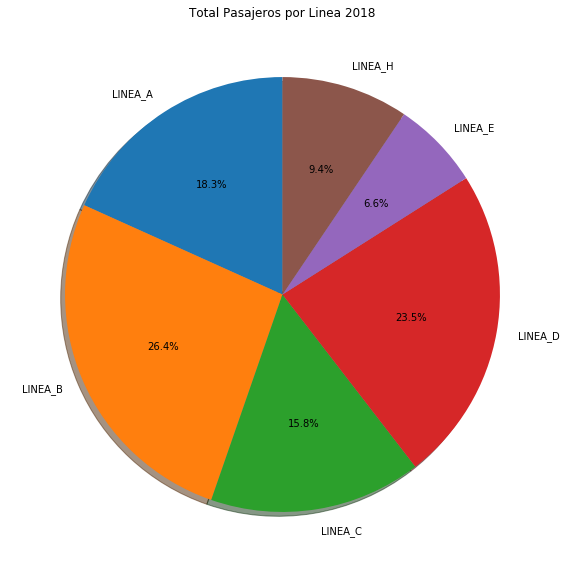

In [4]:
mol_2018 = pd.read_csv(r'/home/ale/Documents/Clases Python /TP FINAL/Todaslineas.csv', sep=";")
totlinea=mol_2018.groupby('LINEA', as_index=False)['TOTAL'].sum()


labels = totlinea.LINEA
sizes = totlinea.TOTAL

fig, axs = plt.subplots(figsize=(30,10))
axs.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
axs.set_title('Total Pasajeros por Linea 2018')


plt.show()


BARRA Y PIE con totales por linea

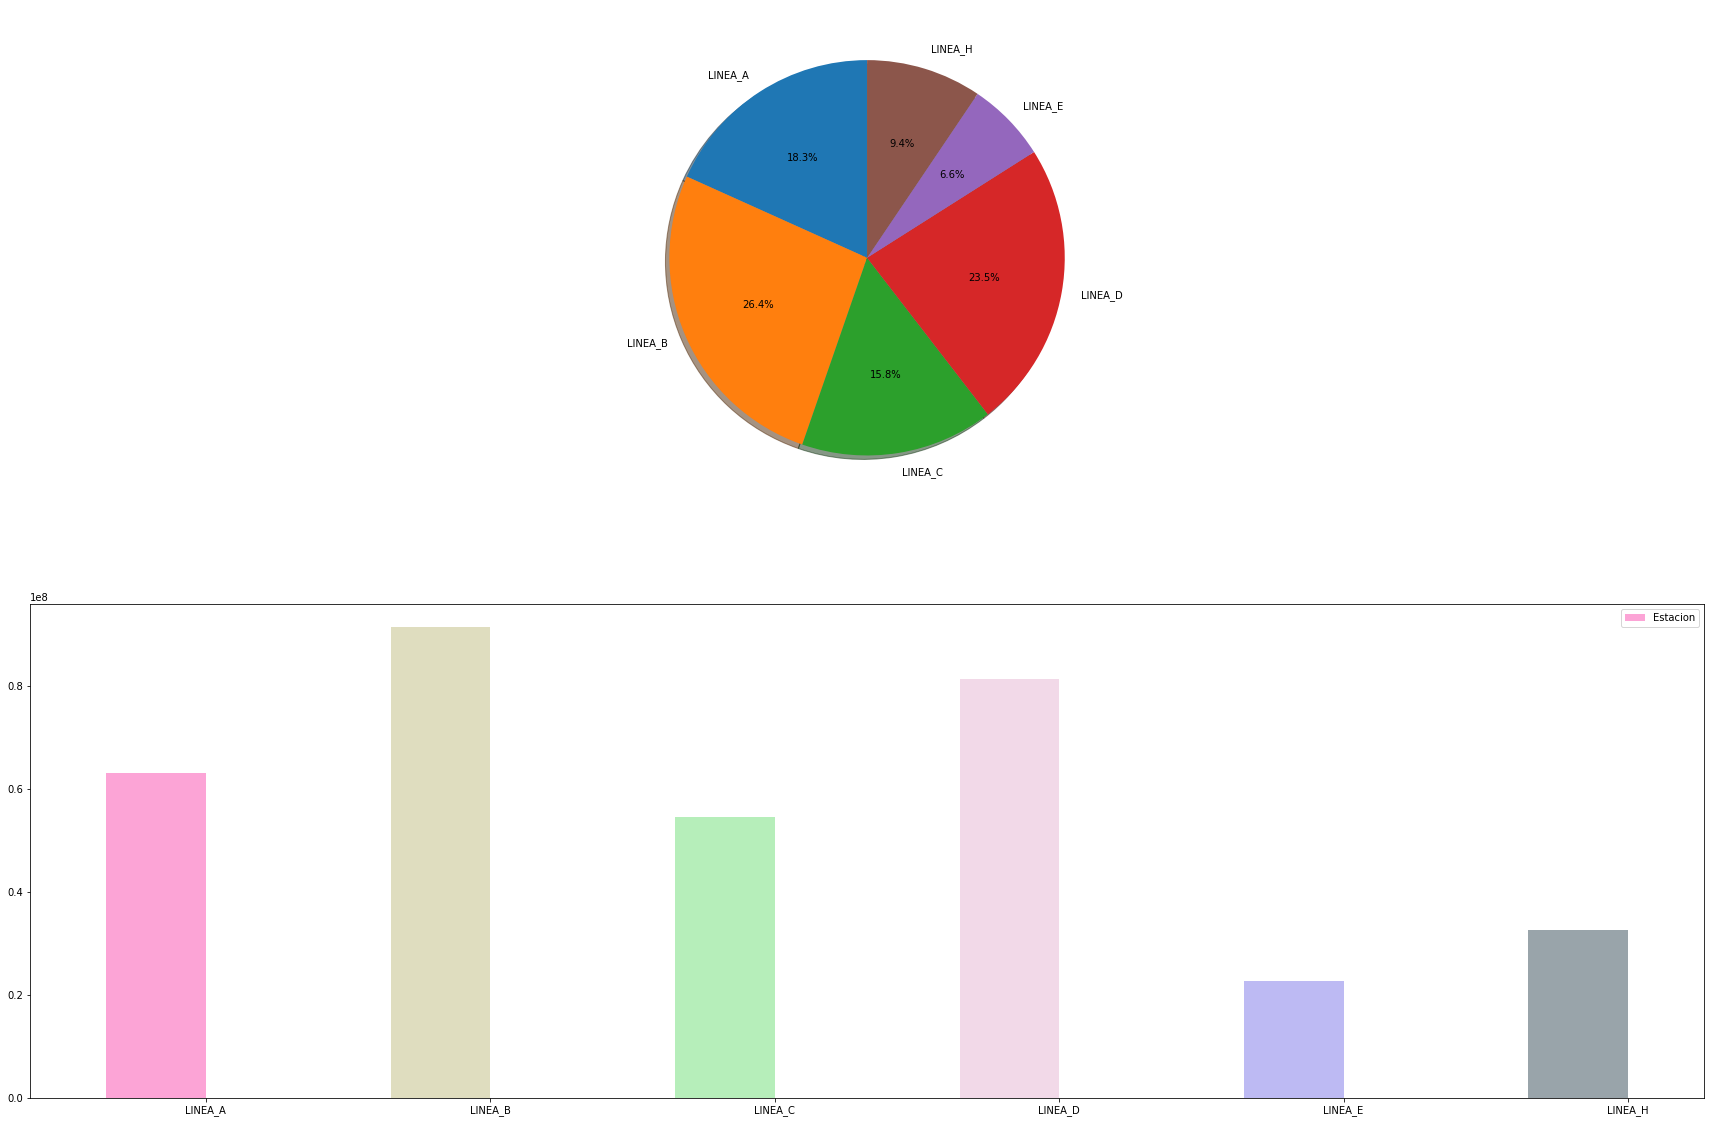

In [3]:
labels = totlinea.LINEA
sizes = totlinea.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#bar chart
index = np.arange(totlinea.LINEA.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots(2, 1, figsize=(30,20))
axs[0].pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     
axs[1].bar(index, totlinea.TOTAL, bar_width,
                alpha=opacity, color=np.random.rand ( 256,3),
                label='Estacion')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(totlinea.LINEA)
axs[1].legend()


#fig.tight_layout()

plt.show()


Grafico LINEAL con totales por linea

In [6]:
totlineames=mol_2018.groupby(['LINEA','Month'], as_index=False)['TOTAL'].sum()

totlineaA=totlineames[totlineames.LINEA=='LINEA_A']
totlineaB=totlineames[totlineames.LINEA=='LINEA_B']
totlineaC=totlineames[totlineames.LINEA=='LINEA_C']
totlineaD=totlineames[totlineames.LINEA=='LINEA_D']
totlineaE=totlineames[totlineames.LINEA=='LINEA_E']
totlineaH=totlineames[totlineames.LINEA=='LINEA_H']

data1 = [go.Scatter(x=totlineaA.Month,y=totlineaA.TOTAL,mode ='lines+markers',
                   name="LineaA",
                   text=""),
         go.Scatter(x=totlineaB.Month,y=totlineaB.TOTAL,mode ='lines+markers',
                   name="LineaB",
                   text=""),
         go.Scatter(x=totlineaC.Month,y=totlineaC.TOTAL,mode ='lines+markers',
                   name="LineaC",
                   text=""),
         go.Scatter(x=totlineaD.Month,y=totlineaD.TOTAL,mode ='lines+markers',
                   name="LineaD",
                   text=""),
         go.Scatter(x=totlineaE.Month,y=totlineaE.TOTAL,mode ='lines+markers',
                   name="LineaE",
                   text=""),
         go.Scatter(x=totlineaH.Month,y=totlineaH.TOTAL,mode ='lines+markers',
                   name="LineaH",
                   text="")]


#data2 = go.Scatter(x=sdf.DESDE,y=sdf['MEAN'].apply(np.round),name="MEAN")

layout = dict(title = 'Total pasajeros por mes 2018',
              xaxis = dict(title = 'Mes',dtick=1),
              yaxis = dict(title = 'Cantidad pasajeros(millones)')
              )

fig = dict(data=data1,layout=layout)


py.iplot(fig)

/home/ale/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Problemas de las lineas ( con dataset de twitter)

In [6]:
twitt = pd.read_csv("/home/ale/Documents/Clases Python /TP FINAL/Twittermetrovias.csv", sep=";")
twitt['Issuetype']=twitt['Issuetype'].apply(lambda x: 0 if 'Normal' in x else 1)
twitt['Month']= pd.DatetimeIndex(twitt['DATE']).month



PIE PROBLEMAS LINEAS

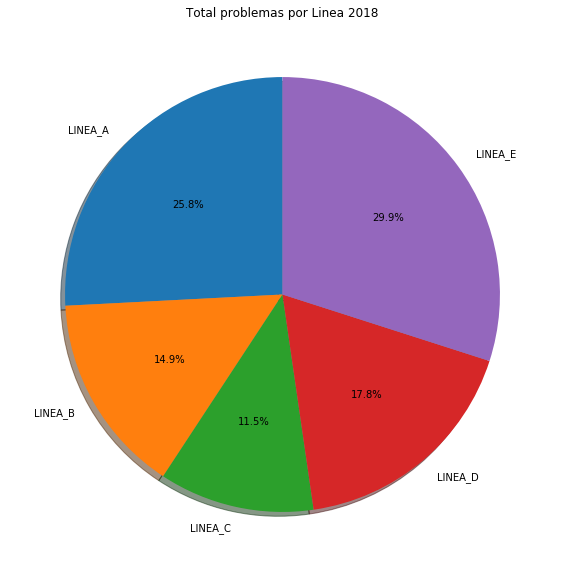

In [7]:
twitttot=twitt.groupby('LINEA', as_index=False)['Issuetype'].sum()


labels = twitttot.LINEA
sizes = twitttot.Issuetype

fig, axs = plt.subplots(figsize=(30,10))
axs.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)     
axs.set_title('Total problemas por Linea 2018')

plt.show()


In [ ]:
BARRA Y PIE con problemas por linea

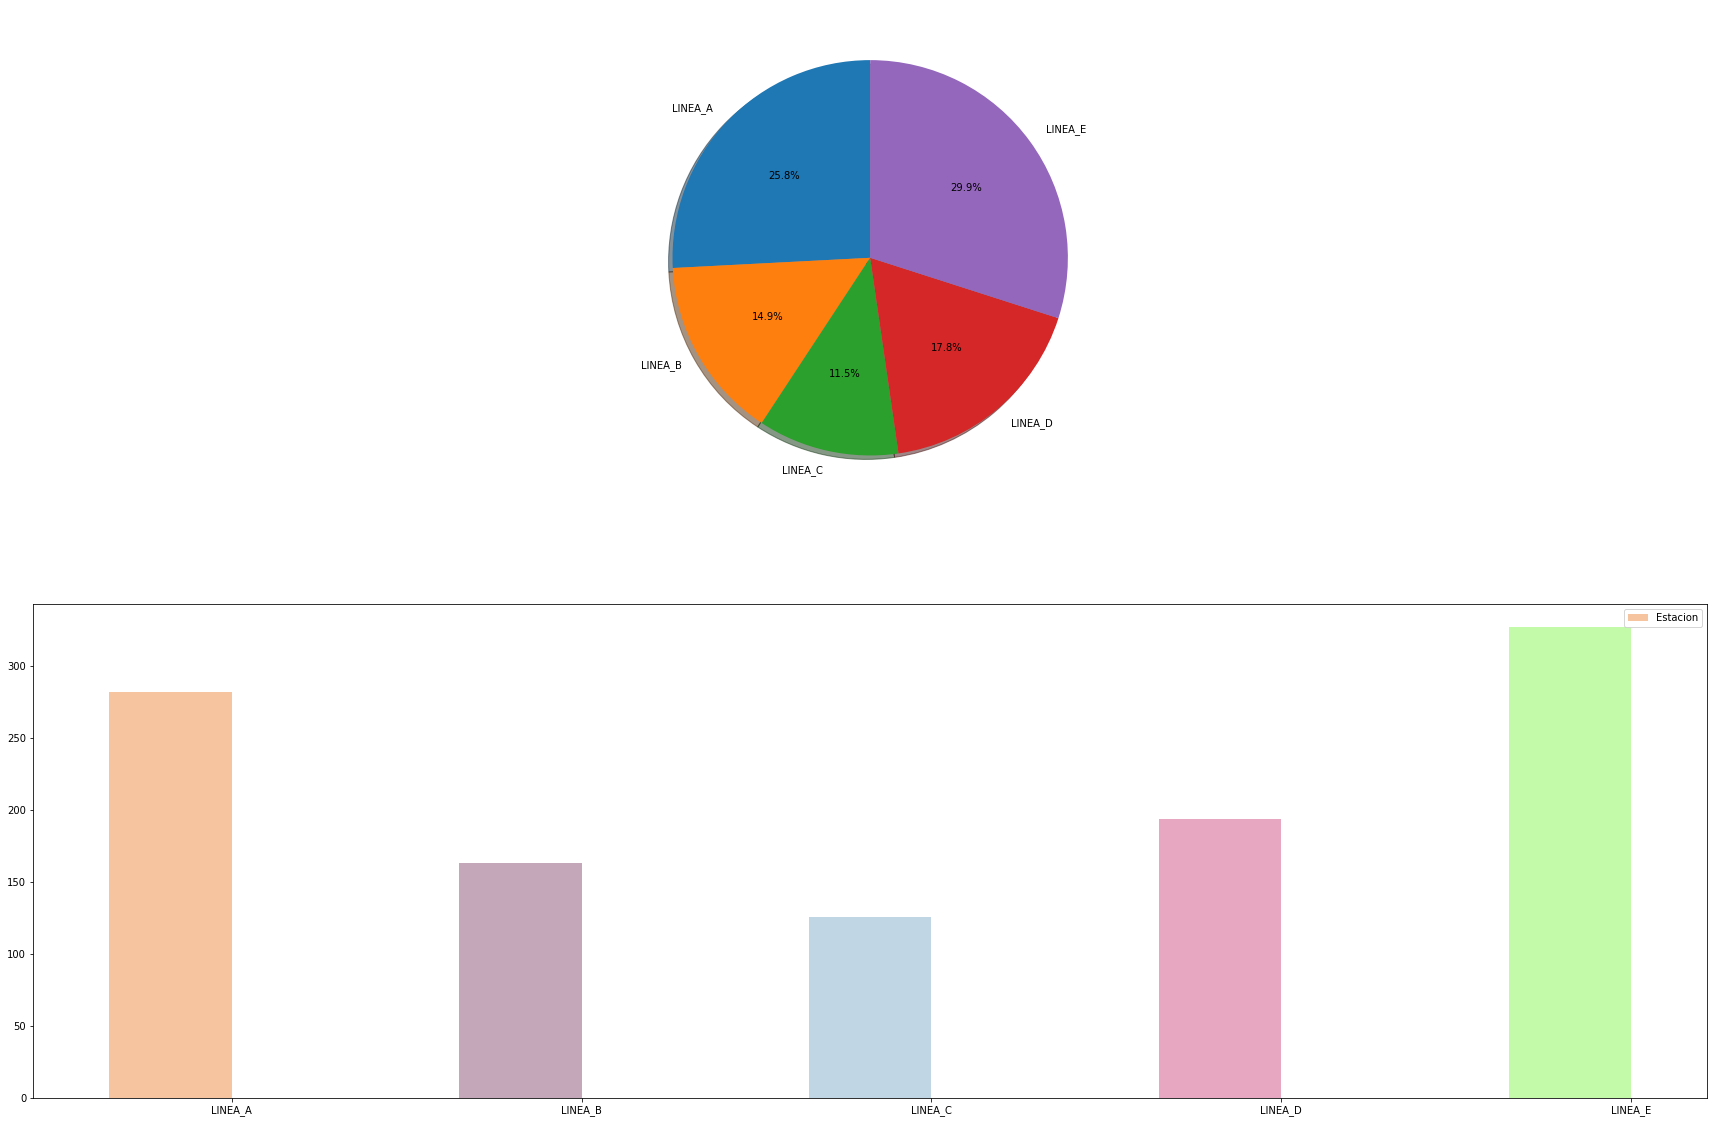

In [9]:
labels = twitttot.LINEA
sizes = twitttot.Issuetype
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#bar chart
index = np.arange(twitttot.LINEA.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots(2, 1, figsize=(30,20))
axs[0].pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     
axs[1].bar(index, twitttot.Issuetype, bar_width,
                alpha=opacity, color=np.random.rand ( 256,3),
                label='Estacion')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(twitttot.LINEA)
axs[1].legend()


#fig.tight_layout()

plt.show()

Grafico problemas de las lineas por linea

In [10]:
twitttot=twitt.groupby(['LINEA','Month'], as_index=False)['Issuetype'].sum()

twitttotA=twitttot[twitttot.LINEA=='LINEA_A']
twitttotB=twitttot[twitttot.LINEA=='LINEA_B']
twitttotC=twitttot[twitttot.LINEA=='LINEA_C']
twitttotD=twitttot[twitttot.LINEA=='LINEA_D']
twitttotE=twitttot[twitttot.LINEA=='LINEA_E']
twitttotH=twitttot[twitttot.LINEA=='LINEA_H']

data1 = [go.Scatter(x=twitttotA.Month,y=twitttotA.Issuetype,mode ='lines+markers',
                   name="LineaA",
                   text=""),
         go.Scatter(x=twitttotB.Month,y=twitttotB.Issuetype,mode ='lines+markers',
                   name="LineaB",
                   text=""),
         go.Scatter(x=twitttotC.Month,y=twitttotC.Issuetype,mode ='lines+markers',
                   name="LineaC",
                   text=""),
         go.Scatter(x=twitttotD.Month,y=twitttotD.Issuetype,mode ='lines+markers',
                   name="LineaD",
                   text=""),
         go.Scatter(x=twitttotE.Month,y=twitttotE.Issuetype,mode ='lines+markers',
                   name="LineaE",
                   text=""),
         go.Scatter(x=twitttotH.Month,y=twitttotH.Issuetype,mode ='lines+markers',
                   name="LineaH",
                   text="")]


#data2 = go.Scatter(x=sdf.DESDE,y=sdf['MEAN'].apply(np.round),name="MEAN")

layout = dict(title = 'Problemas por mes 2018',
              xaxis = dict(title = 'Mes',dtick=1),
              yaxis = dict(title = 'Cantidad de problemas')
              )

fig = dict(data=data1,layout=layout)


py.iplot(fig)

problemas de la linea A

In [17]:
LINEAA=twitt[twitt.LINEA=='LINEA_A']
LINEAATOT=LINEAA.groupby(['LINEA','Month'], as_index=False)['Issuetype'].sum()

data1 = [go.Scatter(x=LINEAATOT.Month,y=LINEAATOT.Issuetype,mode ='lines+markers',
                   name="LineaA")]

layout = dict(title = 'Problemas por mes 2018',
              xaxis = dict(title = 'Mes',dtick=1),
              yaxis = dict(title = 'Cantidad de problemas')
              )

fig = dict(data=data1,layout=layout)


py.iplot(fig)

/home/ale/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



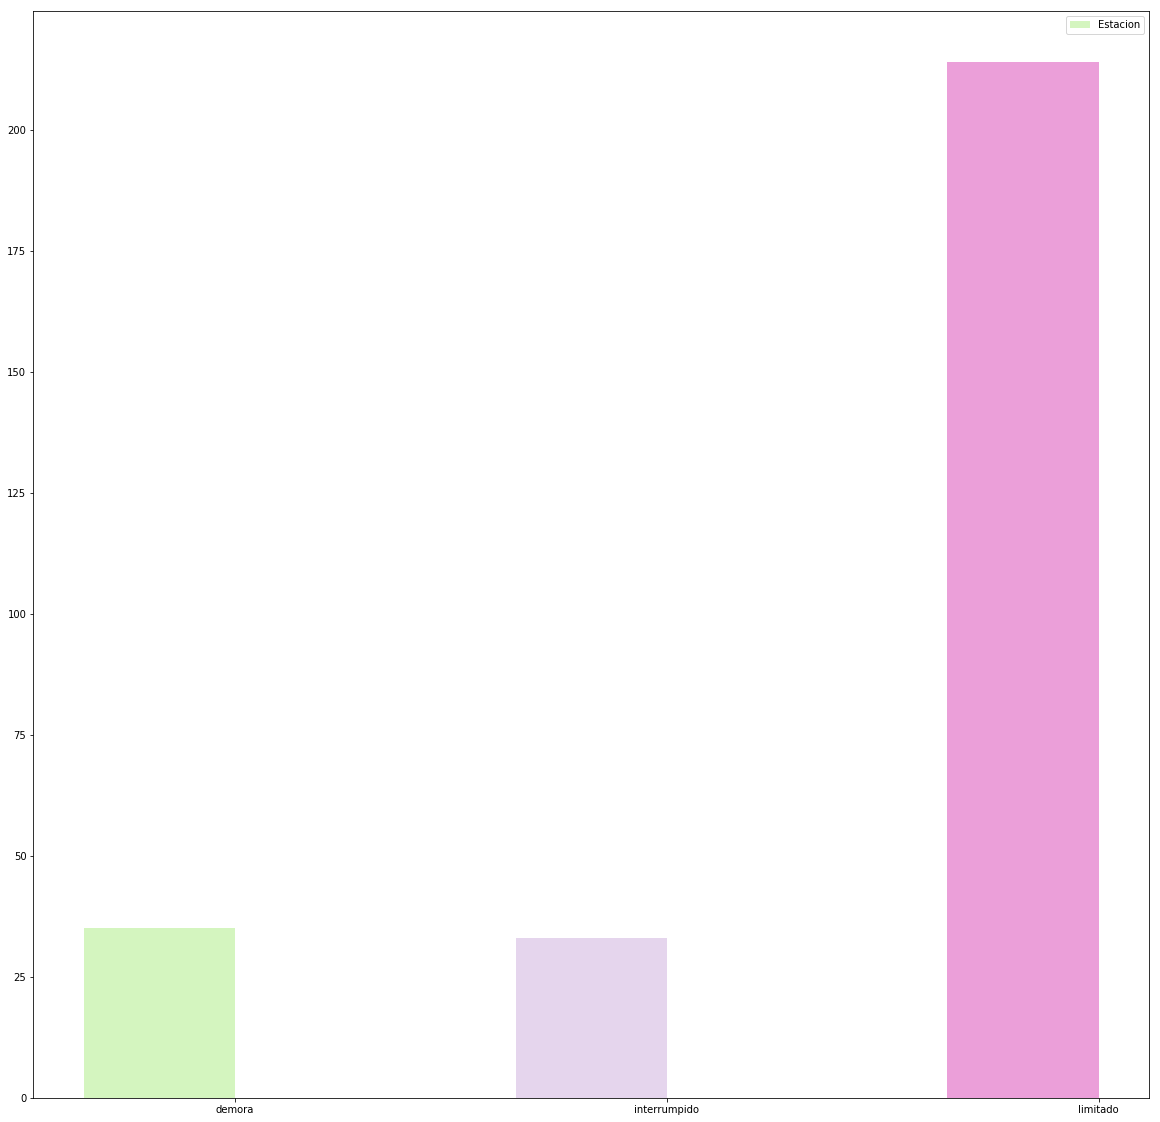

In [38]:

#LINEAA['Issuetype2']=LINEAA['Issuetype'].apply(lambda x: 0 if 'Normal' in x else 1)
#LINEAA['Issuetype']=LINEAA['TEXT'].apply(lambda x: 'demora' if 'demora' in x else 'interrumpido' if 'interrumpido' in x else 'Normal' if 'frecuencia normal' in x else 'limitado' if 'limitado' in x else 'Normal')
#LINEAA
LINEAA2=LINEAA.groupby(['Issuetype'], as_index=False)['Issuetype2'].sum()
LINEAA2=LINEAA2[LINEAA2.Issuetype!='Normal']

index = np.arange(LINEAA2.Issuetype.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots( figsize=(20,20))                  
axs.bar(index, LINEAA2.Issuetype2, bar_width,
                alpha=opacity, color=np.random.rand ( 256,3),
                label='Estacion')
axs.set_xticks(index + bar_width / 2)
axs.set_xticklabels(LINEAA2.Issuetype)
axs.legend()

plt.show()

In [33]:
armar grafico de anomalias con relacion al total
poner al principio masomenos lo de la api de twitter
graficos de barras con lienas max y minimos 

la hora donde se pierde mayor cantidad de plata

,Issuetype,Month,Issuetype2
0,Normal,1,0
1,Normal,2,0
2,Normal,3,0
3,Normal,4,0
4,Normal,5,0
5,Normal,6,0
6,Normal,7,0
7,Normal,8,0
8,Normal,9,0
9,Normal,10,0
